### Entraînement d'un modèle GRU pour la prédiction du prix du Bitcoin
- Ce Notebook entraîne un modèle GRU pour prédire le prix du BTC à court terme.
- Il suit plusieurs étapes : chargement des données, préparation des indicateurs, configuration des hyperparamètres, entraînement et évaluation du modèle.


### 1. Importation des données
- Importation des bibliothèques nécessaires (Pandas, `tech_lib` pour les indicateurs techniques, `os` pour la gestion des fichiers, etc.).
- Chargement du dataset du BTC en fréquence 1 minute sur une période définie.
- Ajout de cibles (`Close_target` et `DirVar_target`) pour la prédiction.

---

### 2. Calcul des indicateurs techniques
- Calcul du Chaikin Money Flow (`cmf`) avec une fenêtre de 60 minutes.
- Calcul de la Volume Weighted Moving Average (`vwma`) avec des fenêtres de 60 et 120 minutes.
- Calcul de l'On-Balance Volume (`obv`).
- Suppression des valeurs `NaN` après le calcul des indicateurs.


In [58]:
import technical_analysis as tech
import pandas as pd
import os
from datetime import datetime
%load_ext autoreload
%autoreload 2

# Import dataset
ticker = 'BTCUSDT'
freq = '1m'
start_date_str = datetime(*(2024, 1, 15, 0, 0, 0)).strftime('%Y%m%d')
end_date_str = datetime(*(2025, 1, 15, 0, 0, 0)).strftime('%Y%m%d')
dataset = pd.read_csv(os.getcwd()+f'\\dataset\\\{ticker}-{freq}-{start_date_str}-{end_date_str}.csv', index_col='Open Time')
dataset['Close_target'] = dataset['Close'].shift(-15)

#Calcul des outputs
#dataset['DirVar_target'] = pd.Series([1 if diff > 0 else 0 for diff in dataset['Close'].diff(1)], index=dataset.index, dtype=int).shift(-1)
#dataset['Return_target'] = dataset['Close'].pct_change().shift(-1)

# Boucle pour calculer les indicateurs avec différentes fenêtres
#window = 60
#dataset[f'cmf_{window}'] = tech.cmf(
#    high=dataset.High, 
#   low=dataset.Low, 
#    close=dataset.Close, 
#    volume=dataset.Volume, 
#    window=window
#)

# Boucle pour calculer les indicateurs avec différentes fenêtres
#for window in [60, 120]:
#    dataset[f'vwma_{window}'] = tech.vwma(
#        close=dataset.Close, 
#        volume=dataset.Volume, 
#        window=window
#    )
    
#dataset['obv'] = tech.obv(dataset.Close, dataset.Volume)

dataset = dataset.dropna()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 2. Assess the stationarity of a process

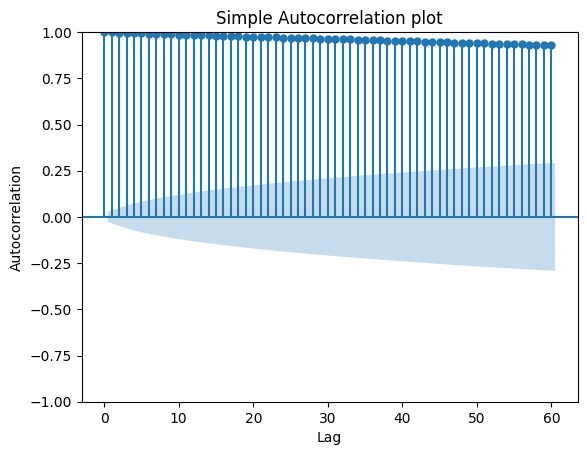

In [60]:
from statsmodels.graphics import tsaplots
from matplotlib import pyplot as plt

tsaplots.plot_acf(dataset['Close'][-5000:], lags=60, alpha=0.05)
plt.title('Simple Autocorrelation plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [61]:
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson

#fit multiple linear regression model
model = ols('Close_target ~ Open + Close + Low + High + Volume', data=dataset)
res = model.fit()

dw = durbin_watson(res.resid)
print(f"Durbin-Watson: {dw}")

Durbin-Watson: 0.13571024127287287


### 3. Kalman filter
**Préférer un EKF pour les séries non-liénaires (notre cas)**

In [62]:
from typing import Tuple, Dict
import pandas as pd
from pykalman import KalmanFilter
import numpy as np

def kalman_filter(
    data: pd.Series,
    noise_variance_window: int = 5,
    noise_variance_fraction: float = 0.01,
    initial_mean: float = None,
    initial_variance_window: int = 10
) -> Dict[str, np.ndarray]:
    """
    Applique un filtre de Kalman à une série temporelle.
    
    Arguments:
        data (pd.Series): Série temporelle des prix.
        noise_variance_window (int): Taille de la fenêtre pour estimer la variance d'observation.
        noise_variance_fraction (float): Fraction pour estimer la covariance de transition.
        initial_mean (float): Moyenne initiale de l'état. Calculée automatiquement si None.
        initial_variance_window (int): Taille de la fenêtre pour estimer la variance initiale.
    
    Returns:
        dict: Dictionnaire contenant les états filtrés et les covariances.
    """
    if data.isnull().any():
        raise ValueError("La série contient des valeurs manquantes. Veuillez les traiter avant d'appliquer le filtre.")
    if len(data) < max(noise_variance_window, initial_variance_window):
        raise ValueError("La série est trop courte pour appliquer le filtre de Kalman.")

    observation_variance = np.var(data.diff().dropna())
    transition_covariance = noise_variance_fraction * observation_variance

    initial_mean = data.iloc[:initial_variance_window].mean() if initial_mean is None else initial_mean
    initial_variance = np.var(data.iloc[:initial_variance_window]) if len(data) >= initial_variance_window else np.var(data)

    kf = KalmanFilter(
        transition_matrices=[1],
        observation_matrices=[1],
        initial_state_mean=initial_mean,
        initial_state_covariance=initial_variance,
        observation_covariance=observation_variance,
        transition_covariance=transition_covariance
    )

    filtered_state_means, filtered_state_covariances = kf.filter(data)

    return {
        "filtered_means": filtered_state_means.ravel(),
        "filtered_covariances": filtered_state_covariances.ravel()
    }


In [63]:
dataset_filter = pd.DataFrame()
for m in ['Open', 'High', 'Low', 'Close']:
    kalman = kalman_filter(
        dataset[m], 
        noise_variance_window=60, 
        noise_variance_fraction=1, 
        initial_mean=None, 
        initial_variance_window=60
    )
    dataset_filter[m] = kalman['filtered_means']
dataset_filter.index = dataset.index
dataset_filter['Volume'] = dataset['Volume']
dataset_filter['obv'] = tech.obv(dataset_filter['Close'], dataset_filter['Volume'])
dataset_filter['Number of Trades'] = dataset['Number of Trades']
dataset_filter['Close_target'] = dataset_filter['Close'].shift(-15)
dataset_filter = dataset_filter.dropna()

In [64]:
diff_filter = dataset[['Open', 'High', 'Low', 'Close']] - dataset_filter[['Open', 'High', 'Low', 'Close']]
diff_filter.describe()

,Open,High,Low,Close
count,527011.000000,527011.000000,527011.000000,527011.000000
mean,0.064161,0.064162,0.064176,0.064169
std,20.973308,19.187790,20.412883,20.974931
min,-1539.786796,-953.586033,-2299.260413,-1538.611805
25%,-8.187531,-7.512347,-7.028895,-8.186634
50%,0.044739,-0.073021,0.179588,0.044230
75%,8.404471,7.163831,7.794377,8.402248
max,658.685659,614.401405,518.002644,659.859244


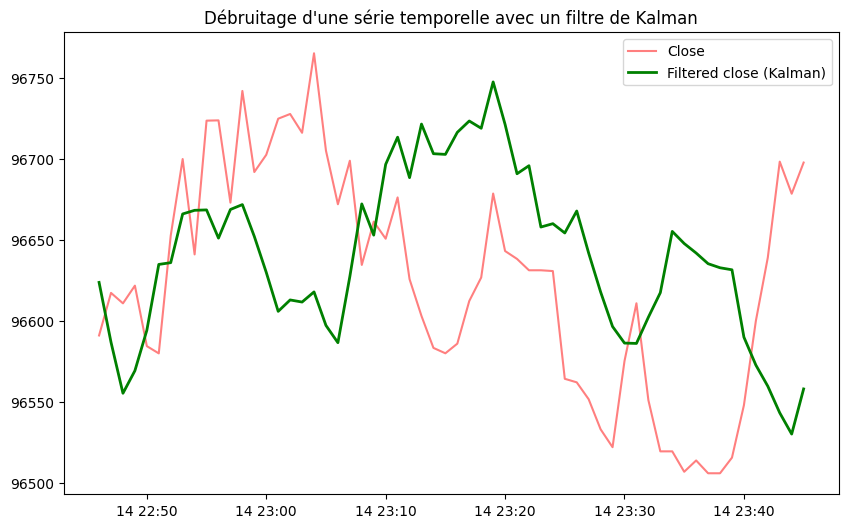

In [66]:
import matplotlib.pyplot as plt
window_plot = 60

plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(dataset.index)[-window_plot:], dataset.Close[-window_plot:], label="Close", color="red", alpha=0.5)
plt.plot(pd.to_datetime(dataset.index)[-window_plot:], dataset_filter.Close[-window_plot:], label="Filtered close (Kalman)", color="green", linewidth=2)
plt.legend()
plt.title("Débruitage d'une série temporelle avec un filtre de Kalman")
plt.show()

### 3. Définition des hyperparamètres et sélection des entrées
- Définition d'une grille de recherche pour les hyperparamètres (`hidden_size`, `num_layers`, `dropout`, `lr`, etc.).
- Sélection des variables d'entrée pour le modèle, incluant les prix (`High`, `Low`, `Open`, `Close`), le volume et les indicateurs calculés.
- Génération de combinaisons d'hyperparamètres et de variables d'entrée pour tester différentes configurations.

In [38]:
import itertools

param_grid = {
    "period_size"   : [100000],
    "hidden_size"   : [8],
    "num_layers"    : [2],
    "dropout"       : [0.15],
    "lr"            : [0.001],
    "batch_size"    : [128],
    "epochs"        : [3],
    "num_workers"   : [4],
    "delta"         : [1],
    "weight_decay"  : [1e-4],
    "train_size"    : [0.7],
    "val_size"      : [0.15],
    "test_size"     : [0.15],
    "seq_size"      : [60],
    "device"        : ["cuda"]
}

inputs = [
    'High', 'Low', 'Open', 'Close', 
    'Volume', 'obv', 'Number of Trades'
]
min_imputs = 8 # set len(dataset.columns) to disable inputs test
outputs = 'Close_target'

param_combinations = list(itertools.product(*param_grid.values()))
input_combinations = [list(itertools.combinations(inputs, r)) for r in range(min_imputs, len(inputs) + 1)]
input_combinations = [item for sublist in input_combinations for item in sublist]

### 4. Entraînement du modèle GRU
- Chargement de la bibliothèque `gru_lib` et initialisation du modèle GRU avec les paramètres définis.
- Définition des hyperparamètres d'entraînement (`lr`, `batch_size`, `epochs`, etc.).
- Prétraitement des données : découpage en ensembles d'entraînement, validation et test.
- Lancement de l'entraînement et affichage des pertes (`Train Loss`, `Validation Loss`).

---

### 5. Sauvegarde des résultats et du modèle
- Création d'un dossier pour sauvegarder les résultats de l'entraînement.
- Sauvegarde des métadonnées (`metada.json`), des pertes (`loss.csv`), des prédictions (`pred.csv`) et du modèle entraîné (`model.pth`).
- Affichage des métriques d'évaluation (`R²`, `MAPE`, `MSE`, `RMSE`).


In [3]:
import winsound
import os
from datetime import datetime
import json
import torch
from gru_pipeline import GRUModel, Pipeline
print(f'Cuda available: {torch.cuda.is_available()}')
print(f'Cuda version: {torch.version.cuda}')
print(f'Cuda device name: {torch.cuda.get_device_name(0)}')
%load_ext autoreload
%autoreload 2
print('\n')

counter = 0
for param_comb in param_combinations:
    for input_comb in input_combinations:
        time_lauch = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f'------------- Launch Time: {time_lauch:<10} ------------- Progress: {(counter):,}/{(len(param_combinations)*len(input_combinations)):,} -------------')

        # Extraire les paramètres pour cette combinaison
        params = dict(zip(param_grid.keys(), param_comb))
        inputs = list(input_comb)

        # Garder la période étudiée
        dataset_subset = dataset.iloc[-params["period_size"]:]
        dataset_subset = dataset_subset.dropna()

        # Initialiser le modèle
        model = GRUModel(
            input_size=len(inputs),
            output_size=1,
            hidden_size=params["hidden_size"], 
            num_layers=params["num_layers"],
            dropout=params["dropout"],
            device=params["device"]
        )

        # Initialiser le pipeline
        pipeline = Pipeline(
            model=model, 
            dataset=dataset_subset,
            inputs=inputs,
            outputs=outputs,
            ticker=ticker,
            freq=freq
        )

        # Définir les hyperparamètres
        pipeline.hyper_param(
            lr=params["lr"], 
            batch_size=params["batch_size"], 
            epochs=params["epochs"],
            num_workers=params["num_workers"],
            delta=params["delta"],
            weight_decay=params["weight_decay"]
        )

        # Prétraiter des données
        pipeline.preprocess(
            train_size=params["train_size"],
            val_size=params["val_size"], 
            test_size=params["test_size"], 
            seq_size=params["seq_size"]
        )

        # Entraîner le modèle et évaluer les résultats
        pipeline.train()
        print(f"\nID: {str(pipeline.id)}")
        pipeline.eval()

        # create folder and files
        folder_path = os.getcwd() + '\\model\\' + str(pipeline.id)
        os.makedirs(folder_path, exist_ok=True)

        metadata = pipeline.metadata()
        with open(folder_path + '\\metada.json', 'w', encoding='utf-8') as f:
            json.dump(metadata, f, ensure_ascii=False, indent=4)

        loss = pipeline.loss()
        loss.to_csv(folder_path + '\\loss.csv', index=False)

        pred = pipeline.pred()
        pred.to_csv(folder_path + '\\pred.csv', index=False)

        torch.save(pipeline.model, folder_path + '\\model.pth') # revoir l'optimisation --> sauvegarder les poids et le modèle séparément

        print("\n")
        counter += 1

winsound.PlaySound("SystemExit", winsound.SND_ALIAS)

Cuda available: True
Cuda version: 12.6
Cuda device name: NVIDIA GeForce RTX 4060
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


------------- Launch Time: 2025-01-27 11:54:56 ------------- Progress: 0/1 -------------
Epoch 1/3, Train Loss: -0.015390, Validation Loss: -0.016337, Time: 0:00:00.316185
Epoch 2/3, Train Loss: -0.016337, Validation Loss: -0.016343, Time: 0:00:00.163537
Epoch 3/3, Train Loss: -0.016340, Validation Loss: -0.016343, Time: 0:00:00.177780

ID: fc41c8a6-c897-463d-a217-12ad40dffd8a
Time elapsed: 0.6575
Train Loss: -0.016340
Val Loss: -0.016343
Test Loss: -0.016344
R^2 : -0.2857
R^2 ajusté : -0.2935
MAPE : 18258.4785
MSE : 0.000858
RMSE : 0.029299


